<a href="https://colab.research.google.com/github/mae001/Machine-Learning-projects/blob/main/04_transfer_learning_feature_extraction_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-07-24 16:06:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   129MB/s    in 1.2s    

2024-07-24 16:06:42 (129 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#unzip
with zipfile.ZipFile("/content/10_food_classes_10_percent.zip", 'r') as zip_ref:
  zip_ref.extractall()

In [ ]:
#walking through all the directories
import os
for (dirpath, dirnames, filenames) in os.walk('/content/10_food_classes_10_percent'):
  print(f'There are {len(dirpath)} directories and {len(filenames)} images in {dirpath}')

There are 35 directories and 0 images in /content/10_food_classes_10_percent
There are 41 directories and 0 images in /content/10_food_classes_10_percent/train
There are 51 directories and 75 images in /content/10_food_classes_10_percent/train/ice_cream
There are 47 directories and 75 images in /content/10_food_classes_10_percent/train/pizza
There are 55 directories and 75 images in /content/10_food_classes_10_percent/train/chicken_wings
There are 47 directories and 75 images in /content/10_food_classes_10_percent/train/sushi
There are 52 directories and 75 images in /content/10_food_classes_10_percent/train/fried_rice
There are 55 directories and 75 images in /content/10_food_classes_10_percent/train/chicken_curry
There are 47 directories and 75 images in /content/10_food_classes_10_percent/train/steak
There are 47 directories and 75 images in /content/10_food_classes_10_percent/train/ramen
There are 56 directories and 75 images in /content/10_food_classes_10_percent/train/grilled_sal

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224, 224) #we come up with image shape and batch size ourselves
BATCH_SIZE=32

train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images')
train_data_10_percent = train_datagen.flow_from_directory(directory = train_dir,
                                                        target_size = IMAGE_SHAPE,
                                                        class_mode = 'categorical',
                                                        batch_size = BATCH_SIZE)

print('Test images')
test_data_10_percent = test_datagen.flow_from_directory(directory = test_dir,
                                                        target_size = IMAGE_SHAPE,
                                                        class_mode = 'categorical',
                                                        batch_size = BATCH_SIZE)


Training images
Found 750 images belonging to 10 classes.
Test images
Found 2500 images belonging to 10 classes.


In [ ]:
for folder in os.listdir(train_dir): #return me the train directory in list format
  print(folder)

ice_cream
pizza
chicken_wings
sushi
fried_rice
chicken_curry
steak
ramen
grilled_salmon
hamburger


<ipython-input-6-800c1a4dfb7e>:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, n)


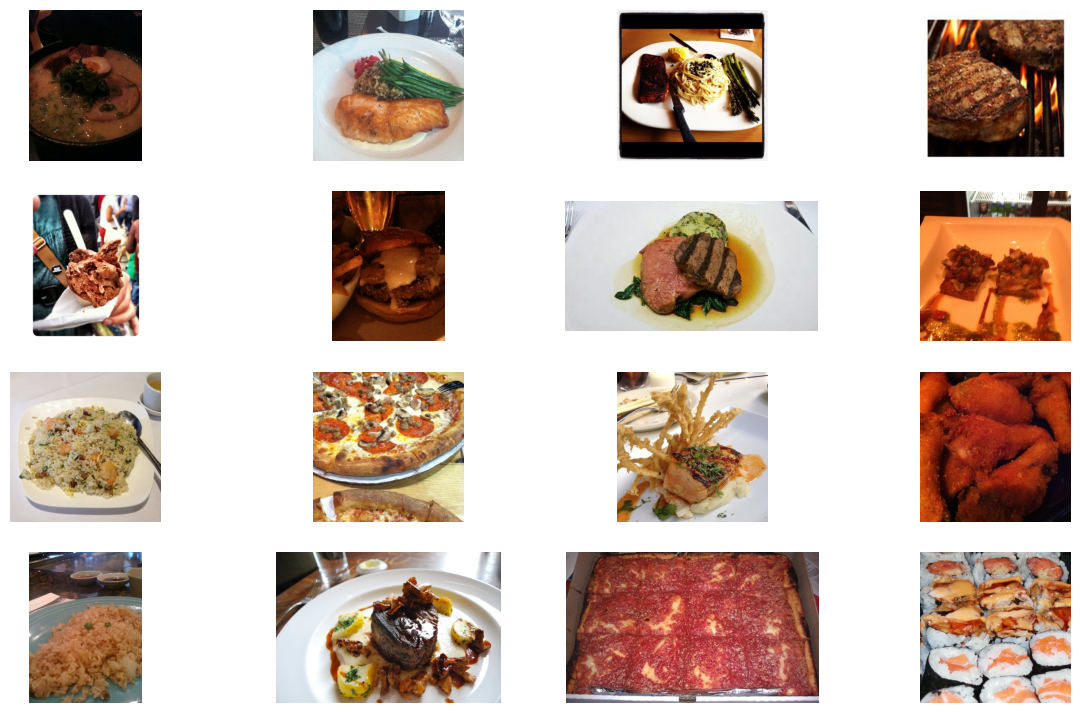

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image

images = []
for folder in os.listdir(train_dir):
  for image in os.listdir(train_dir+'/' + folder):
    images.append(os.path.join(train_dir,folder,image))

plt.figure(1, figsize=(15, 9))
plt.axis('off')
n = 0
for i in range(16):
  n+=1
  random_img = random.choice(images)
  imgs = mpimg.imread(random_img)
  plt.subplot(4, 4, n)
  plt.axis('off')
  plt.imshow(imgs)

In [ ]:
resnet_url = 'https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2'
efficientnet_url = 'https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1'


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE + (3,) #made it 3 dimensional bc the pics are colored

(224, 224, 3)

In [ ]:
def create_model(model_url, num_classes = 10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False, #we freeze this layer w False
                                           name = 'Feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE + (3,))

  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [ ]:
train_data_10_percent.num_classes

10

In [ ]:
resnet_model.layers[0]

In [ ]:
resnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard files to {log_dir}')
  return tensorboard_callback

In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  batch_size = BATCH_SIZE,
                                  epochs = 8,
                                  validation_data = test_data_10_percent,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_steps = len(test_data_10_percent),
                                  callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                           experiment_name = 'resnet50V2')])

Saving Tensorboard files to tensorflow_hub/resnet50V2/20240724-160709
Epoch 1/8
24/24 [==============================] - 27s 672ms/step - loss: 1.8882 - accuracy: 0.3760 - val_loss: 1.1755 - val_accuracy: 0.6328
Epoch 2/8
24/24 [==============================] - 10s 445ms/step - loss: 0.8847 - accuracy: 0.7333 - val_loss: 0.8554 - val_accuracy: 0.7300
Epoch 3/8
24/24 [==============================] - 10s 431ms/step - loss: 0.6159 - accuracy: 0.8253 - val_loss: 0.7733 - val_accuracy: 0.7468
Epoch 4/8
24/24 [==============================] - 10s 412ms/step - loss: 0.4730 - accuracy: 0.8680 - val_loss: 0.7078 - val_accuracy: 0.7688
Epoch 5/8
24/24 [==============================] - 10s 445ms/step - loss: 0.3729 - accuracy: 0.9173 - val_loss: 0.7017 - val_accuracy: 0.7748
Epoch 6/8
24/24 [==============================] - 11s 453ms/step - loss: 0.3077 - accuracy: 0.9387 - val_loss: 0.6748 - val_accuracy: 0.7832
Epoch 7/8
24/24 [==============================] - 12s 509ms/step - loss: 0.25

In [ ]:
resnet_model.evaluate(test_data_10_percent) #score

79/79 [==============================] - 8s 105ms/step - loss: 0.6459 - accuracy: 0.7916


[0.6458901762962341, 0.7915999889373779]

In [ ]:
def plot_loss_curvers(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  #Plot loss
  plt.plot(epochs, loss, label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'val_accuracy')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

# model 2

In [ ]:
efficientnet_model = create_model(
    model_url = efficientnet_url,
    num_classes = train_data_10_percent.num_classes
)

efficientnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [ ]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  batch_size = BATCH_SIZE,
                                  epochs = 8,
                                  validation_data = test_data_10_percent,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_steps = len(test_data_10_percent),
                                  callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                           experiment_name = 'resnet50V2')])

Saving Tensorboard files to tensorflow_hub/resnet50V2/20240724-161604
Epoch 1/8
24/24 [==============================] - 25s 555ms/step - loss: 1.9120 - accuracy: 0.4093 - val_loss: 1.3307 - val_accuracy: 0.7176
Epoch 2/8
24/24 [==============================] - 10s 419ms/step - loss: 1.0798 - accuracy: 0.7707 - val_loss: 0.8848 - val_accuracy: 0.8132
Epoch 3/8
24/24 [==============================] - 10s 415ms/step - loss: 0.7724 - accuracy: 0.8360 - val_loss: 0.7085 - val_accuracy: 0.8380
Epoch 4/8
24/24 [==============================] - 9s 400ms/step - loss: 0.6226 - accuracy: 0.8640 - val_loss: 0.6188 - val_accuracy: 0.8536
Epoch 5/8
24/24 [==============================] - 10s 423ms/step - loss: 0.5224 - accuracy: 0.8880 - val_loss: 0.5630 - val_accuracy: 0.8604
Epoch 6/8
24/24 [==============================] - 10s 431ms/step - loss: 0.4526 - accuracy: 0.9093 - val_loss: 0.5253 - val_accuracy: 0.8620
Epoch 7/8
24/24 [==============================] - 10s 412ms/step - loss: 0.396